# final_analysis.py.ipynb
This notebook plots the figures for the manuscript. It starts with a single source of input data (`integrate_data.csv`). We restrict the analysis to our sample of interest (cells infected by a WT virus). Then, we calculate the necessary outcome metrics and plot the outcomes of infection.

## Notebook setup
Import Python modules:

In [1]:
from IPython.display import display
from pymodules.gini import *
from scipy import stats
from svgutils.compose import *
import altair as alt
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotnine as p9
import scikit_posthocs as sp
import seaborn as sns
import subprocess

Set the theme for plots:

In [2]:
p9.theme_set(p9.theme_classic())
CBPALETTE = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

Set output folder for figures:

In [3]:
figure_dir = 'results/figures'
if not os.path.exists(figure_dir):
    # Create a new directory because it does not exist 
    os.makedirs(figure_dir)
    print(f"Made `{figure_dir}` directory ")
else:
    print(f"Directory `{figure_dir}` already exists.")

Directory `results/figures` already exists.


## Input data
### Read input data
The general structure of the `integrated_data_csv` file is that each cell barcode is listed on a row, and features of that cell are listed in columns. Cells that have more than one valid viral barcode identified may have multiple rows--one for each valid viral barcode.

In [4]:
all_samples_csv = 'results/viral_fastq10x/all_samples.csv'
integrated_data = pd.read_csv(all_samples_csv)
integrated_data

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,transcriptome_UMIs_fluNA,...,pacbio_UMIs_fluPB1,pacbio_UMIs_fluPB2,mutation_support_fluHA,mutation_support_fluM,mutation_support_fluNA,mutation_support_fluNP,mutation_support_fluNS,mutation_support_fluPA,mutation_support_fluPB1,mutation_support_fluPB2
0,AAACGAAAGCCACCGT,infected,wt,41743,451,0.010804,6,101,54,26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,TTTGATCTCCCGTTCA,uninfected,none,63150,3,0.000048,0,0,1,0,...,0.0,0.0,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
6388,TTTGGAGAGTTGCCTA,uninfected,none,65941,12,0.000182,1,0,6,1,...,0.0,0.0,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
6389,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,23.0,7.0,Not Applicable,Not Applicable,31/31,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable
6390,TTTGGAGGTATCGTTG,infected,wt,150130,3526,0.023486,8,93,1668,45,...,23.0,7.0,Not Applicable,Not Applicable,31/31,Not Applicable,Not Applicable,Not Applicable,Not Applicable,Not Applicable


### Combine data for each cell into single row
Process the dataframe so that each cell becomes a single row. Progeny contributions are summed for each cell, source, and barcoded gene (e.g. supernatant_freq_fluHA) and listed in a column.

In [6]:
min_viral_barcode_freq = 1e-5  # value assigned to unobserved viral barcodes

# aggregate observed viral barcodes for each gene and cell
processed_data = (
    integrated_data
    .groupby(["sample", "cell_barcode", "barcoded_gene"], as_index=False)
    .aggregate(
        n_viral_barcodes=pd.NamedAgg("viral_barcode", lambda v: v.astype(bool).astype(int).sum()),
        viral_barcodes=pd.NamedAgg("viral_barcode", "; ".join),
        freq_supernatant=pd.NamedAgg("freq_supernatant", "sum"),
        freq_second_infection=pd.NamedAgg("freq_second_infection", "sum"),
    )
)
assert processed_data.notnull().all().all()

# get barcoded viral genes
barcoded_genes = processed_data["barcoded_gene"].unique().tolist()

# now pivot so just one row per cell
pivoted_dfs = []
for col_to_pivot, fill_value in [
    ("n_viral_barcodes", 0),
    ("viral_barcodes", ""),
    ("freq_supernatant", pd.NA),
    ("freq_second_infection", pd.NA),
]:
    pivoted_dfs.append(
        processed_data
        .pivot_table(
            index=["sample", "cell_barcode"],
            columns="barcoded_gene",
            values=col_to_pivot,
            fill_value=fill_value,
            aggfunc='sum',
        )
        .rename_axis(None, axis=1)
        .rename(columns={gene: f"{col_to_pivot}_{gene}" for gene in barcoded_genes})
    )
assert all((pivoted_dfs[0].index == df.index).all() for df in pivoted_dfs)
processed_data = pd.concat(pivoted_dfs, axis=1).reset_index()

# now add back in cell-specific information
# Require infected cells since the above measurements only make sense for
# infected cells.
cell_info = (
    integrated_data
    [['sample', 'cell_barcode', 'infected', 'infecting_viral_tag',
      'total_UMIs', 'viral_UMIs', 'frac_viral_UMIs', 'n_viral_genes'] +
     [c for c in integrated_data.columns
      if re.match("transcriptome_UMIs_flu|frac_UMIs_flu|present_flu|pacbio_UMIs|mutations_|mutation_support_", c)]
    ]
    .drop_duplicates()
)

assert set(processed_data[["sample", "cell_barcode"]]).issubset(cell_info[["sample", "cell_barcode"]])
processed_data = (
    cell_info.query('infected == "infected"')
    .merge(processed_data, on=["sample", "cell_barcode"], how="left", validate="one_to_one")
)

# add columns explaining missing genes
present_columns = {c: c.replace("present_flu", "") for c in processed_data.columns
                   if re.match("present_flu", c)}

processed_data = (
    processed_data
    .assign(
        all_viral_genes=lambda x: x['n_viral_genes'] == len(present_columns),
        missing_viral_genes=lambda x: x.apply(lambda row:
            "; ".join(val for (key, val) in present_columns.items() if not row[key]),
            axis=1)
    )
)

# check for complete pacbio data for all expressed viral genes
def virus_fully_sequenced(row):
    row_dict = row.to_dict()
    for key, val in row_dict.items():
        if re.fullmatch("present_flu\w+", key) and val:
            gene = key.split("_")[1]
            if row_dict[f"pacbio_UMIs_{gene}"] >= 2:
                return True
    else:
        return False

processed_data = (
    processed_data
    .assign(virus_fully_sequenced=lambda x: x.apply(virus_fully_sequenced, axis=1))
)

# check to see if cell expresses both barcoded viral genes
processed_data["all_barcoded_genes"] = np.logical_and.reduce(
    [processed_data[f"present_{gene}"] for gene in barcoded_genes] +
    [processed_data[f"freq_supernatant_{gene}"].notnull() for gene in barcoded_genes] +
    [processed_data[f"freq_second_infection_{gene}"].notnull() for gene in barcoded_genes]
)

# annotate cells with both complete pacbio data and both barcoded viral genes
def sequenced_and_barcoded(row):
    if row['virus_fully_sequenced'] and row['all_barcoded_genes']:
        return "sequenced and barcoded"
    elif row['virus_fully_sequenced']:
        return "sequenced"
    elif row['all_barcoded_genes']:
        return "barcoded"
    else:
        return "not sequenced or barcoded"
processed_data["sequenced_and_barcoded"] = (
    processed_data.apply(sequenced_and_barcoded, axis=1)
)

display(processed_data)

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
0,trial1,AAACGAAAGCCACCGT,infected,wt,41743,451,0.010804,6,101,54,...,,0.00001,<NA>,0.00001,<NA>,False,NP; PB2,False,False,not sequenced or barcoded
1,trial1,AAACGCTAGTTCACTG,infected,syn,11572,4702,0.406326,7,650,2075,...,AAATTCTTGGGGCGAC; TGATAGCGTAGACGTT; ATGAATTATA...,0.001942,0.002176,0.002218,0.001432,False,PA,False,True,barcoded
2,trial1,AAAGAACGTAATTGGA,infected,syn,24525,3948,0.160979,7,456,1340,...,,0.000077,<NA>,0.000416,<NA>,False,NA,False,False,not sequenced or barcoded
3,trial1,AAAGGATCATTGCAAC,infected,wt,17304,888,0.051318,7,160,144,...,,0.000013,<NA>,0.000064,<NA>,False,NP,False,False,not sequenced or barcoded
4,trial1,AAAGGGCGTGTATTCG,infected,both,12578,6213,0.493958,8,390,3719,...,NaN,NaN,NaN,NaN,NaN,True,,False,False,not sequenced or barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
948,trial3,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
949,trial3,TTGGGATTCCGATTAG,infected,syn,137623,6652,0.048335,8,262,3656,...,GTTTCGTGAGCATGTA,0.00001,0.00001,0.00001,0.00001,True,,True,True,sequenced and barcoded
950,trial3,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,True,True,sequenced and barcoded
951,trial3,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


### Restrict analysis to WT infected cells
We only want to plot our sample of interest, which is made up of cells infected by a WT virus. We will exclude uninfected cells, infected multiplets (transcriptomes derived from both WT and dblSyn cells), and infected dblSyn cells.

In [38]:
wt_infected_cells = (
    processed_data
    .query('infected == "infected" and infecting_viral_tag == "wt"'))
wt_infected_cells

,sample,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,frac_viral_UMIs,n_viral_genes,transcriptome_UMIs_fluHA,transcriptome_UMIs_fluM,...,viral_barcodes_fluNA,freq_supernatant_fluHA,freq_supernatant_fluNA,freq_second_infection_fluHA,freq_second_infection_fluNA,all_viral_genes,missing_viral_genes,virus_fully_sequenced,all_barcoded_genes,sequenced_and_barcoded
0,trial1,AAACGAAAGCCACCGT,infected,wt,41743,451,0.010804,6,101,54,...,,0.00001,<NA>,0.00001,<NA>,False,NP; PB2,False,False,not sequenced or barcoded
3,trial1,AAAGGATCATTGCAAC,infected,wt,17304,888,0.051318,7,160,144,...,,0.000013,<NA>,0.000064,<NA>,False,NP,False,False,not sequenced or barcoded
5,trial1,AAAGGGCGTTGCCTAA,infected,wt,36880,6704,0.181779,7,1079,6,...,,0.00001,<NA>,0.00001,<NA>,False,M,False,False,not sequenced or barcoded
8,trial1,AAAGTGAAGGAAGTCC,infected,wt,19936,428,0.021469,6,186,27,...,,0.00002,<NA>,0.00002,<NA>,False,NP; PB2,False,False,not sequenced or barcoded
10,trial1,AACAACCGTGATTCTG,infected,wt,54425,2669,0.049040,8,240,1364,...,TCCTAAGTTAGTACCT,0.00002,0.002127,0.000058,0.032429,True,,False,True,barcoded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,trial3,TTGCGTCCACCCTCTA,infected,wt,160497,1816,0.011315,7,241,678,...,GAGCTCCTGTATTGCC,0.00001,0.00001,0.00001,0.00001,False,PA,True,True,sequenced and barcoded
948,trial3,TTGGGATGTAACGATA,infected,wt,161690,9470,0.058569,8,407,4600,...,TAAAAAATGTCTCATG,0.001014,0.001284,0.000154,0.000015,True,,True,True,sequenced and barcoded
950,trial3,TTTACCAGTCGCTTAA,infected,wt,114567,1434,0.012517,7,125,609,...,ATTTGGATGTAGGGGC; TTGGAGGAGACCCGTG,0.000106,0.001222,0.00002,0.000029,False,PA,True,True,sequenced and barcoded
951,trial3,TTTCACAAGCCAAGCA,infected,wt,68424,2308,0.033731,6,475,796,...,GGTATCAGTTATTGTT,0.00001,0.00001,0.00001,0.00001,False,NS; PB1,True,True,sequenced and barcoded


In [42]:
for sample in wt_infected_cells['sample'].unique():
    n_wt_infected_cells = wt_infected_cells.query(f'sample == "{sample}"')["cell_barcode"].nunique()
    print(f'There are {n_wt_infected_cells} WT infected cells in the {sample} dataset.')

There are 378 WT infected cells in the trial1 dataset.
There are 254 WT infected cells in the trial3 dataset.


## General transcriptional outcomes of infection
### Plot viral transcription
I will plot the histogram of viral transcription. I need to know where to set the limits and bins, so I will look up the maximum viral transcription fraction for these data.

In [44]:
print(f'The maximum fraction of viral transcription '
      f'in an infected cells is {wt_infected_cells["frac_viral_UMIs"].max()}')

The maximum fraction of viral transcription in an infected cells is 0.8403226839106217


/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 3 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/viral_transcription.svg


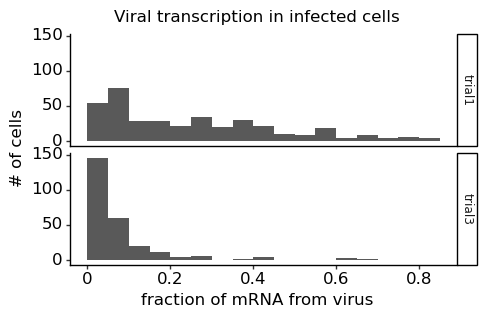

<ggplot: (8780487676639)>

In [49]:
viral_transcription_file = figure_dir+'/'+'viral_transcription.svg'

viral_transcription_plot = (
    p9.ggplot(
        wt_infected_cells,
        p9.aes(x='frac_viral_UMIs')) +
    p9.geom_histogram(breaks=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                              0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85]) +
    p9.facet_grid('sample~') +
    p9.ggtitle(f'Viral transcription in infected cells') +
    p9.labs(x='fraction of mRNA from virus',
            y='# of cells') +
    p9.theme(figure_size=(5, 3),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))
viral_transcription_plot.save(filename = viral_transcription_file)
display(viral_transcription_plot)

### Plot viral genes per infected cell

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 3 x 3 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/genes_per_cell.svg


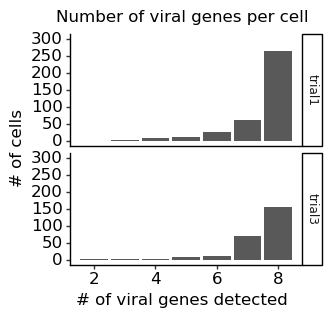

<ggplot: (8780486590196)>

In [57]:
genes_per_cell_file = figure_dir+'/'+'genes_per_cell.svg'

genes_per_cell_plot = (
    p9.ggplot(
        wt_infected_cells[['sample', 'cell_barcode', 'n_viral_genes']].drop_duplicates(),
        p9.aes(x='n_viral_genes')) +
    p9.geom_bar(stat='count', position='dodge') +
    p9.facet_grid('sample~') +
    p9.ggtitle('Number of viral genes per cell') +
    p9.labs(x='# of viral genes detected',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,300], breaks=[0,50,100,150,200,250,300]) +
    p9.theme(figure_size=(3, 3),
                plot_title=p9.element_text(size=12),
                axis_title=p9.element_text(size=12),
                axis_text=p9.element_text(size=12, color="black")))
genes_per_cell_plot.save(filename = genes_per_cell_file)
display(genes_per_cell_plot)

### Plot viral gene presence or absence

To generate this plot, I need to tabulate how many cells express or do not express each viral gene. I will make a new dataframe with cell barcode, frac_viral_UMIs, and gene as columns. For each cell, I will list whether the gene is present and the fraction of gene UMIs in the cell.

In [92]:
gene_present_by_cell = (
    wt_infected_cells
    [['sample', 'cell_barcode',
      'present_fluPB2', 'present_fluPB1',
      'present_fluPA', 'present_fluHA',
      'present_fluNP', 'present_fluNA',
      'present_fluM', 'present_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['sample', 'cell_barcode'],
        var_name='gene',
        value_name='gene_present')
)
gene_present_by_cell['gene'] = (
    gene_present_by_cell['gene']
    .str.split('_').str[-1])

gene_frac_by_cell = (
    wt_infected_cells
    [['sample', 'cell_barcode', 'frac_viral_UMIs',
      'frac_UMIs_fluPB2', 'frac_UMIs_fluPB1',
      'frac_UMIs_fluPA', 'frac_UMIs_fluHA',
      'frac_UMIs_fluNP', 'frac_UMIs_fluNA',
      'frac_UMIs_fluM', 'frac_UMIs_fluNS']]
    .drop_duplicates()
    .melt(
        id_vars=['sample', 'cell_barcode', 'frac_viral_UMIs'],
        var_name='gene',
        value_name='frac_gene_UMIs')
)
gene_frac_by_cell['gene'] = (
    gene_frac_by_cell['gene']
    .str.split('_').str[-1])

viral_genes_by_cell = pd.merge(
    left=gene_present_by_cell,
    right=gene_frac_by_cell,
    on=['sample', 'cell_barcode','gene'],
    how='outer'
)
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .replace(['fluPB2', 'fluPB1', 'fluPA', 'fluHA',
              'fluNP', 'fluNA', 'fluM', 'fluNS'],
             ['PB2', 'PB1', 'PA', 'HA',
              'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene'].astype('category'))
viral_genes_by_cell['gene'] = (
    viral_genes_by_cell['gene']
    .cat.reorder_categories(
        ['PB2', 'PB1', 'PA', 'HA',
         'NP', 'NA', 'M', 'NS']))
viral_genes_by_cell['gene_present'] = (
    viral_genes_by_cell['gene_present']
    .replace([True,False],
             ["Gene present", "Gene absent"]))

for sample in wt_infected_cells['sample'].unique():
    assert viral_genes_by_cell.query(f'sample == "{sample}"')['cell_barcode'].unique().all() == \
           wt_infected_cells.query(f'sample == "{sample}"')['cell_barcode'].unique().all(), \
           f"Cell barcodes don't match for {sample}"

display(viral_genes_by_cell)

gene_absence_rate = pd.DataFrame(
    viral_genes_by_cell
    .groupby(['sample', 'gene'])
    ['gene_present']
    .value_counts(normalize=True)
    .reset_index(name='fraction_cells'))


assert(gene_absence_rate['gene'].nunique() == 8)

display(gene_absence_rate)

,sample,cell_barcode,gene,gene_present,frac_viral_UMIs,frac_gene_UMIs
0,trial1,AAACGAAAGCCACCGT,PB2,Gene absent,0.010804,0.000000
1,trial1,AAAGGATCATTGCAAC,PB2,Gene present,0.051318,0.000347
2,trial1,AAAGGGCGTTGCCTAA,PB2,Gene present,0.181779,0.002359
3,trial1,AAAGTGAAGGAAGTCC,PB2,Gene absent,0.021469,0.000000
4,trial1,AACAACCGTGATTCTG,PB2,Gene present,0.049040,0.000220
...,...,...,...,...,...,...
5051,trial3,TTGCGTCCACCCTCTA,NS,Gene present,0.011315,0.002885
5052,trial3,TTGGGATGTAACGATA,NS,Gene present,0.058569,0.022673
5053,trial3,TTTACCAGTCGCTTAA,NS,Gene present,0.012517,0.004836
5054,trial3,TTTCACAAGCCAAGCA,NS,Gene absent,0.033731,0.000015


,sample,gene,gene_present,fraction_cells
0,trial1,PB2,Gene present,0.949735
1,trial1,PB2,Gene absent,0.050265
2,trial1,PB1,Gene present,0.952381
3,trial1,PB1,Gene absent,0.047619
4,trial1,PA,Gene present,0.920635
5,trial1,PA,Gene absent,0.079365
6,trial1,HA,Gene present,0.902116
7,trial1,HA,Gene absent,0.097884
8,trial1,NP,Gene present,0.955026
9,trial1,NP,Gene absent,0.044974


Plot the fraction of infected cells missing each viral gene.

/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 4 x 3 in image.
/home/dbacsik/.conda/envs/barcoded_flu_pdmH1N1_final_analysis/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: results/figures/gene_absence_plot.svg


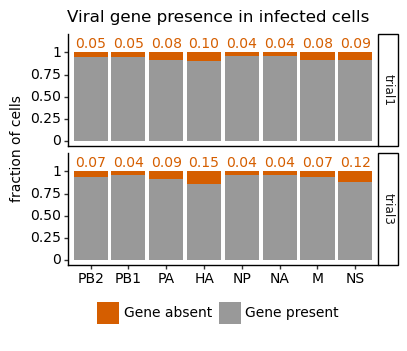

<ggplot: (8780481888690)>

In [96]:
gene_absence_file = figure_dir+'/'+'gene_absence_plot.svg'

gene_absence_plot = (
    p9.ggplot(gene_absence_rate,
              p9.aes(x='gene',
                     y='fraction_cells',
                     fill='gene_present')) +
    p9.geom_bar(stat='identity') +
    p9.geom_text(data=gene_absence_rate.query('gene_present == "Gene absent"'),
           mapping=p9.aes(x='gene',
                          y=1.1,
                          label='fraction_cells'),
                          format_string='{:.2f}',
                          size=10,
                          color=CBPALETTE[6]) +
    p9.facet_grid('sample~') +
    p9.ggtitle('Viral gene presence in infected cells') +
    p9.labs(x = '', y='fraction of cells') +
    p9.scale_y_continuous(limits=[0,1.15],
                          breaks=[0,0.25,0.5,0.75,1])+
    p9.theme(figure_size=(4, 3),
       plot_title=p9.element_text(size=12),
       axis_title=p9.element_text(size=10),
       axis_text=p9.element_text(size=10, color="black"),
       legend_position='bottom',
       legend_box_spacing=0.2,
       legend_title=p9.element_blank(),
       legend_text=p9.element_text(size=10)) +
    p9.scale_fill_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_absence_plot.save(filename = gene_absence_file)
display(gene_absence_plot)

### Make composite Fig 2
Make a composite figure showing viral transcription, number of viral genes per cell, and rate of viral gene absence.

**N.b. For some reason this cell and the ones immediatebly above need to be run manually to generate a correct figure. When run automatically, panel A is oversized.**

In [116]:
fig2_file = figure_dir+'/'+'fig2.svg'

fig2 = (Figure("32cm", "26cm",
       Panel(
            Grid(20, 20),
           SVG(viral_transcription_file),
           Text("A", 5, 15, size=14)).scale(2),
       Panel(
           SVG(genes_per_cell_file),
           Text("B", 5, 15, size=14)).scale(2).move(720,0),
       Panel(
           SVG(gene_absence_file),
           Text("C", 5, 15, size=14)).scale(2).move(0,470),
       ))
display(fig2)
fig2.save(fig2_file)

### Plot viral gene presence or absence raw data
For each single infected cell, plot the expression of each viral gene relative to total viral expression. Color by whether gene was called as present or absent.

In [ ]:
gene_expression_file = figure_dir+'/'+'gene_expression_plot.svg'

gene_expression_plot = (
    p9.ggplot(viral_genes_by_cell,
               p9.aes(x='frac_viral_UMIs',
                      y='frac_gene_UMIs',
                      color='gene_present')) +
    p9.geom_point(alpha=0.3, size=3) +
    p9.facet_wrap('~gene', ncol=4) +
    p9.labs(x='fraction of mRNA from virus',
            y='fraction of mRNA\nfrom specific viral gene') +
    p9.scale_x_log10(breaks=[0.01,0.03,0.1,0.3]) +
    p9.scale_y_log10(breaks=[1e-4,1e-2,1]) +
    p9.theme(figure_size=(8, 4),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black"),
             axis_text_x=p9.element_text(rotation=90),
             legend_position='top',
             legend_box_spacing=0,
             legend_title=p9.element_blank(),
             legend_text=p9.element_text(size=12),
             strip_text=p9.element_text(size=12)) +
    p9.scale_color_manual([CBPALETTE[6],CBPALETTE[0]]))

gene_expression_plot.save(filename = gene_expression_file)
display(gene_expression_plot)

## Viral genome sequencing
### Plot viral transcription in fully-sequenced cells
For later analyses, I will require the cells to have PacBio sequencing information for all expressed viral genes, so that we can call consensus genomes. I want to see how viral transcription activity is associated with our ability to fully sequence a viral genome.


In [ ]:
fully_sequenced_file = figure_dir+'/'+'fully_sequenced_plot.svg'

fully_sequenced_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='virus_fully_sequenced',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=wt_infected_cells.groupby('virus_fully_sequenced').nunique().reset_index(),
                 mapping=p9.aes(y=0.74,
                                label='cell_barcode'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Incomplete sequencing', 'Complete sequencing']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

fully_sequenced_plot.save(filename = fully_sequenced_file)
display(fully_sequenced_plot)

Now, generate a dataframe that is a subset of `wt_infected_cells`, containing just cells with complete PacBio sequencing of all expressed viral genes.

In [ ]:
fully_sequenced_cells = (
    wt_infected_cells
    .query('virus_fully_sequenced == True'))
display(fully_sequenced_cells)

### Aggregate mutation information
Viral mutation information from the PacBio sequencing is currently spread across many columns (one for each gene). I want to aggregate all viral mutaiton information into a single column so that I can display this on plots in the future. I will also annotate cells by whether they have non-synonymous mutations.

In [ ]:
def viral_mutations(row):
    row_dict = row.to_dict()
    mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutations.append(f"{gene}: {val}")
    return ", ".join(mutations)

def nonsynonymous_mutations(row):
    row_dict = row.to_dict()
    nonsynonymous_mutations = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutations.append(f"{gene}: {x}")
    return ", ".join(nonsynonymous_mutations)

def nonsynonymous_mutation_count(row):
    row_dict = row.to_dict()
    nonsynonymous_mutation_count = 0
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                for x in val.split(' '):
                    if "synonymous" in x:
                        pass
                    elif "noncoding" in x:
                        pass
                    else:
                        nonsynonymous_mutation_count += 1
    return nonsynonymous_mutation_count

def mutation_support(row):
    row_dict = row.to_dict()
    support_vals = []
    for key, val in row_dict.items():
        if re.fullmatch("mutation_support_flu\w+", key) and val:
            gene = key.replace("mutation_support_flu", "")
            if val != "Not Applicable":
                support_vals.append(f"{gene}: {val}")
    return ", ".join(support_vals)

def mutated_genes(row):
    row_dict = row.to_dict()
    mutated_genes = []
    for key, val in row_dict.items():
        if re.fullmatch("mutations_flu\w+", key) and val:
            gene = key.replace("mutations_flu", "")
            if val == "Not Detected":
                assert not row_dict[f"present_flu{gene}"]
            elif val != "WT":
                mutated_genes.append(gene)
    return ", ".join(mutated_genes)

def label_cells(row):
    cell_label = None
    if row['all_viral_genes'] == True:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Complete unmutated genome"
        else:
            cell_label = "Complete mutated genome"
    elif row['all_viral_genes'] == False:
        if row['has_nonsynonymous_mutations'] == False:
            cell_label = "Missing viral gene(s)"
        else:
            cell_label = "Missing viral gene(s) and\nnon-synonymous mutations"
    return cell_label

fully_sequenced_cells = (
    fully_sequenced_cells
    .assign(
        viral_mutations=lambda x: x.apply(viral_mutations, axis=1),
        nonsynonymous_mutations=lambda x: x.apply(nonsynonymous_mutations, axis=1),
        mutation_support=lambda x: x.apply(mutation_support, axis=1),
        mutated_genes=lambda x: x.apply(mutated_genes, axis=1),
        has_mutations=lambda x: x["mutated_genes"].astype(bool),
        has_nonsynonymous_mutations=lambda x: x["nonsynonymous_mutations"].astype(bool),
        nonsynonymous_mutation_count=lambda x: x.apply(nonsynonymous_mutation_count, axis=1),
        cell_label=lambda x: x.apply(label_cells, axis=1).astype('category')
    )
)
display(fully_sequenced_cells)

### Viral genotype statistics
Calculate how many infected cells we characterized, how many conensus viral sequences have mutations, and what kinds of mutations they carry.

In [ ]:
mutated_cell_counts = (
    pd.DataFrame(
        fully_sequenced_cells.groupby(['cell_label'])
        ['cell_barcode'].nunique()).reset_index()
    .rename(columns={'cell_barcode': 'n_cells'}))

mutated_cell_counts['cell_label'] = (
    mutated_cell_counts['cell_label']
    .cat.reorder_categories(
        ['Missing viral gene(s) and\nnon-synonymous mutations', 'Missing viral gene(s)', 
        'Complete mutated genome', 'Complete unmutated genome']))

display(mutated_cell_counts)

### Plot viral genotype statistics

In [ ]:
mutated_cell_counts_file = figure_dir+'/'+'mutated_cell_counts_plot.svg'

mutated_cell_counts_plot = (
    p9.ggplot(mutated_cell_counts,
              p9.aes(x='cell_label',
                     y='n_cells',
                     width=0.85)) +
    p9.geom_bar(stat='identity') +
    p9.coord_flip() +
    p9.ggtitle('Consensus viral genome sequences                                 ') +
    p9.labs(x = '', y='# of infected cells') +
    p9.ylim([0,45]) +
    p9.theme(figure_size=(3, 2),
       plot_title=p9.element_text(size=12),
       axis_title=p9.element_text(size=12),
       axis_text=p9.element_text(size=11, color="black")))

mutated_cell_counts_plot.save(filename = mutated_cell_counts_file)
display(mutated_cell_counts_plot)

### Plot number of non-synonymous mutations per cell.

In [ ]:
mutations_per_cell_file = figure_dir+'/'+'mutations_per_cell.svg'

mutations_per_cell_plot = (
    p9.ggplot(
        fully_sequenced_cells,
        p9.aes(x='nonsynonymous_mutation_count')) +
    p9.geom_bar() +
    p9.ggtitle(f'Number of mutations per viral genome') +
    p9.labs(x='# of non-synonymous\nmutations',
            y='# of cells') +
    p9.scale_y_continuous(limits=[0,75], breaks=[0,25,50,75]) +
    p9.theme(figure_size=(3, 2),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=11, color="black"),
             legend_box_spacing=0.2,
             legend_title=p9.element_blank()))
mutations_per_cell_plot.save(filename = mutations_per_cell_file)
display(mutations_per_cell_plot)

### Make composite Fig 3
Make a composite figure showing viral genotypes and number of mutations per genome.

In [ ]:
fig3_file = figure_dir+'/'+'fig3.svg'

fig3 = (Figure("25cm", "7cm",
       Panel(
#           Grid(20, 20),
           SVG(mutated_cell_counts_file),
           Text("A", 5, 15, size=14)).scale(1.5),
       Panel(
           SVG(mutations_per_cell_file).move(15,0),
           Text("B", 5, 15, size=14)).scale(1.5).move(500,0),
       ))
display(fig3)
fig3.save(fig3_file)

## Progeny production measurements
### Plot viral transcription in cells that express both barcoded genes
How does total viral transcription correlate with expressing both viral genes needed for progeny contribution meausrements?

In [ ]:
barcoded_cells = wt_infected_cells.query("all_barcoded_genes")
display(barcoded_cells)

In [ ]:
barcoded_cells_file = figure_dir+'/'+'barcoded_cells_plot.svg'

barcoded_cells_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='all_barcoded_genes',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=wt_infected_cells.groupby('all_barcoded_genes').nunique().reset_index(),
                 mapping=p9.aes(y=0.74,
                                label='cell_barcode'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Missing barcoded gene(s)', 'Both barcoded genes']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

barcoded_cells_plot.save(filename = barcoded_cells_file)
display(barcoded_cells_plot)

## Cells with all measurements
### Select subset of cells with complete sequencing and both barcoded viral genes
In the next section, I will calculate progeny contributions for cells that have complete long-read sequencing and express both barcoded viral genes. I want to count how many cells meet these criteria, and how many fail one or both of these criteria.

In [ ]:
sequenced_barcoded_cell_counts = (wt_infected_cells
        .groupby("sequenced_and_barcoded")
        .aggregate(n_cells=pd.NamedAgg("cell_barcode", "count"))
        .reset_index()
)
sequenced_barcoded_cell_counts['sequenced_and_barcoded'] = (
    sequenced_barcoded_cell_counts['sequenced_and_barcoded']
    .astype('category')
    .cat
    .reorder_categories(['not sequenced or barcoded',
              'barcoded',
              'sequenced',
              'sequenced and barcoded'])
)
sequenced_barcoded_cell_counts['selected_cells'] = (
    sequenced_barcoded_cell_counts['sequenced_and_barcoded'] == \
    "sequenced and barcoded"
)
sequenced_barcoded_cells = fully_sequenced_cells.query('sequenced_and_barcoded == "sequenced and barcoded"')
display(sequenced_barcoded_cells)

### Plot number of cells with or without complete sequencing and both barcoded genes

In [ ]:
selected_cells_file = figure_dir+'/'+'selected_cells_plot.svg'

selected_cells_plot = (
    p9.ggplot(sequenced_barcoded_cell_counts,
               p9.aes(x='sequenced_and_barcoded',
                      y='n_cells',
                      width=0.85)) +
    p9.geom_bar(stat='identity', position='dodge') +
    p9.geom_text(p9.aes(y=98, label='n_cells'), size=11) +
    p9.labs(x='',
            y='# of cells') +
    p9.coord_flip() +
    p9.scale_y_continuous(limits=[0,98], breaks=[0,20,40,60,80]) +
    p9.scale_x_discrete(labels=["Incomplete sequencing and\nmissing barcoded gene(s)",
                                "Both barcoded genes",
                                "Complete sequencing",
                                "Complete sequencing and\nboth barcoded genes"]) +
    p9.theme(figure_size=(3.6, 1.75),
       plot_title=p9.element_text(size=12),
       axis_title=p9.element_text(size=12),
       axis_text=p9.element_text(size=11, color="black")))

selected_cells_plot.save(filename = selected_cells_file)
display(selected_cells_plot)

### Plot viral transcription in cells with complete sequencing and both barcoded viral genes
Do the cells that meet these criteria have a different distribution of viral transcription, or are we subsampling the data in a fairly non-biased way?

In [ ]:
sequenced_and_barcoded_file = figure_dir+'/'+'sequenced_and_barcoded_plot.svg'

sequenced_and_barcoded_plot = (
    p9.ggplot(wt_infected_cells,
               p9.aes(x='factor(sequenced_and_barcoded == "sequenced and barcoded")',
                      y='frac_viral_UMIs')) +
    p9.geom_jitter(alpha=0.3, size=3, width=0.2) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.geom_text(data=pd.DataFrame(sequenced_barcoded_cell_counts.groupby('selected_cells')['n_cells'].sum().reset_index()),
                 mapping=p9.aes(
                     x='selected_cells',
                     y=0.74,
                     label='n_cells'),
                 size=12) +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.scale_y_continuous(limits=[0,0.75], breaks=[0,0.25,0.5,0.75]) +
    p9.scale_x_discrete(labels=['Incomplete sequencing or\nmissing barcoded gene(s)', 'Complete sequencing and\nboth barcoded genes']) +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

sequenced_and_barcoded_plot.save(filename = sequenced_and_barcoded_file)
display(sequenced_and_barcoded_plot)

### Make composite Fig S4
Assemble a composite figure showing how many cells are sequenced completely, have both barcoded viral genes, and the relationship of these criteria to total viral transcription.

In [ ]:
figS4_file = figure_dir+'/'+'figS4.svg'

figS4 = (Figure("27cm", "11cm",
       Panel(
#           Grid(20, 20),
           SVG(fully_sequenced_file).move(15,10),
           Text("A", 0, 20, size=18)),
       Panel(
           SVG(barcoded_cells_file).move(0,10),
           Text("B", 0, 20, size=18)).move(380,0),
       Panel(
           SVG(selected_cells_file).move(0,20),
           Text("C", 0, 20, size=18)).move(0,150),
       Panel(
           SVG(sequenced_and_barcoded_file).move(10,20),
           Text("D", 0, 20, size=18)).move(380,150),
       )).scale(1.3)
display(figS4)
figS4.save(figS4_file)

### How many cells are contributing progeny?
With these data, we can ask a simple question about the progeny population. Among the sequenced, barcoded cells, how many contribute any progeny?

In [ ]:
n_sequenced_barcoded_cells = (sequenced_barcoded_cells['cell_barcode'].nunique())
print(f'There are {n_sequenced_barcoded_cells} in the final dataset with complete progeny measurements and complete sequencing.')

In [ ]:
(integrated_data[integrated_data['cell_barcode']
                 .isin(sequenced_barcoded_cells["cell_barcode"].to_list())]
 .groupby(['contributes_progeny_supernatant', 'contributes_progeny_second_infection'])
 ['cell_barcode']
 .nunique())

### Calculate progeny contribution of cells with complete sequencing and both barcoded viral genes
Next, I will calculate the contribution of each infected cell to the progeny population. I will normalize the the progeny viral barcode frequences among source and gene (e.g. 'supernatant fluHA'). Then, I will take the geometric mean of both barcoded genes to estimate the progeny contribution for each infected cell:

In [ ]:
for condition in ["supernatant", "second_infection"]:
    for gene in barcoded_genes:
        # normalize among selected cells and within barcoded gene
        col = f"freq_{condition}_{gene}"
        sequenced_barcoded_cells[col] = (
            sequenced_barcoded_cells[col] /
            sequenced_barcoded_cells[col].sum()
        ).astype(float)
    # calculate geometric mean of normalized values
    mean_col = f"freq_{condition}"
    sequenced_barcoded_cells[mean_col] = (
        sequenced_barcoded_cells[f"{mean_col}_fluHA"]
        * sequenced_barcoded_cells[f"{mean_col}_fluNA"]
    )**(1 / 2)
    sequenced_barcoded_cells[mean_col] = (
        sequenced_barcoded_cells[mean_col] /
        sequenced_barcoded_cells[mean_col].sum()
    ).astype(float)

display(sequenced_barcoded_cells)

### Export CSV of cells with complete sequencing data
To generate this plot, we needed to provide progeny contribution measurements where possible. This is why this task is performed **after** estimating progeny contributions. Cells with complete PacBio data without progeny contribution measurements will have null value.

In [ ]:
# Bring in progeny production measurements when available
fully_sequenced_cells_CSV = 'results/pacbio/fully_sequenced_cells.csv'

fully_sequenced_cells = pd.merge(
    left=fully_sequenced_cells,
    right=sequenced_barcoded_cells[['cell_barcode', 'freq_supernatant', 'freq_second_infection']],
    on='cell_barcode',
    how='left',
    validate='one_to_one'
)
display(fully_sequenced_cells)
print(f"Writing fully sequenced cells data to CSV: {fully_sequenced_cells_CSV}")
fully_sequenced_cells.to_csv(fully_sequenced_cells_CSV)

### Generate viral genome plot using R script
There is an R script that generates the viral genomes plot using `gggenes`. We call that here using `subprocess.call`.

In [ ]:
# call R script to generate viral genomes plot
viral_genomes_file = figure_dir+'/'+'viral_genomes_plot.pdf'
rscript_file = "scripts/viral_genomes_plot.R"
subprocess.call(" ".join(["Rscript", rscript_file, fully_sequenced_cells_CSV, viral_genomes_file]), shell = True)

## Heterogeneity in viral products
### Calculate Gini coefficients
Calculate Gini coefficient for viral transcription, physical progeny production, and infectious progeny production.

In [ ]:
total_array = wt_infected_cells['frac_viral_UMIs'].to_numpy()
total_gini = gini(total_array)
print(f"The Gini coefficient for viral transcription in all {n_wt_infected_cells} infected cells is {total_gini:0f}\n")


distributions = {'viral_transcription': 'frac_viral_UMIs',
                 'physical_progeny_virions': 'freq_supernatant',
                 'infectious_progeny_virions': 'freq_second_infection'}
gini_coeffs = {'viral_transcription': None,
               'physical_progeny_virions': None,
               'infectious_progeny_virions': None,}

print(f"For the {n_sequenced_barcoded_cells} cells with complete progeny measurements and complete sequencing:")
for distribution, variable in distributions.items():
    dist_array = sequenced_barcoded_cells[variable].to_numpy()
    gini_coeff = gini(dist_array)
    gini_coeffs[distribution] = gini_coeff
    print(f"{distribution} has a Gini coefficient of {gini_coeff:0f}")

### Plot histograms of viral transcription, physical progeny (supernatant), and infectious progeny (second infection) frequency

In [ ]:
physical_progeny_file = figure_dir+'/'+'physical_progeny_plot.svg'

physical_progeny_plot = (
    p9.ggplot(
        sequenced_barcoded_cells,
        p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28]) +
    p9.ylim(0,85) +
    p9.ggtitle(f'Physical progeny production') +
    p9.labs(x='fraction physical virions',
            y='# of cells') +
    p9.annotate('text',
                label=f'Gini={round(gini_coeffs["physical_progeny_virions"], 2)}',
                x=0.24, y=75,
                size=12) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=10, color="black"),
             legend_title=p9.element_text(size=12),
             legend_title_align='center'))
physical_progeny_plot.save(filename = physical_progeny_file)
display(physical_progeny_plot)

In [ ]:
infectious_progeny_file = figure_dir+'/'+'infectious_progeny_plot.svg'

infectious_progeny_plot = (
    p9.ggplot(
        sequenced_barcoded_cells,
        p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28]) +
    p9.ylim(0,85) +
    p9.ggtitle(f'Infectious progeny production') +
    p9.labs(x='fraction infectious virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(gini_coeffs["infectious_progeny_virions"], 2)}',
                x=0.24, y=75,
                size=12) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=10, color="black"),
             legend_title=p9.element_text(size=12),
             legend_title_align='center'))
infectious_progeny_plot.save(filename = infectious_progeny_file)
display(infectious_progeny_plot)

In [ ]:
transcription_selected_cells_file = figure_dir+'/'+'transcription_selected_cells_plot.svg'

transcription_selected_cells_plot = (
    p9.ggplot(
        sequenced_barcoded_cells,
        p9.aes(x='frac_viral_UMIs')) +
    p9.geom_histogram(breaks=[0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,
                              0.4,0.45,0.5,0.55,0.6,0.65,0.7]) +
    p9.ylim(0,85) +
    p9.ggtitle(f'Viral transcription') +
    p9.labs(x='fraction mRNA from virus',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(gini_coeffs["viral_transcription"], 2)}',
                x=0.6, y=75,
                size=12) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=10, color="black"),
             legend_title=p9.element_text(size=12),
             legend_title_align='center'))
transcription_selected_cells_plot.save(filename = transcription_selected_cells_file)
display(transcription_selected_cells_plot)

### Make composite Fig 4
Make composite figure of viral transcription, physical progeny production, and infectious progeny production.

In [ ]:
fig4_file = figure_dir+'/'+'fig4.svg'

fig4 = (Figure("33cm", "12cm",
       Panel(
#           Grid(20, 20),
           SVG(physical_progeny_file).move(0,15),
           Text("A", 5, 15, size=14)).scale(2),
       Panel(
           SVG(infectious_progeny_file).move(0,15),
           Text("B", 5, 15, size=14)).scale(2).move(420,0),
       Panel(
           SVG(transcription_selected_cells_file).move(0,15),
           Text("C", 5, 15, size=14)).scale(2).move(820,0),
       ))
display(fig4)
fig4.save(fig4_file)

### Calculate cumulative sum of viral products
How many cells does it take to contribute half of the transcripts or progeny? Note that in this dataframe I will calculate the cumulative sum on the absolute number of viral UMIs across all cells, rather than the fraction of viral UMIs within a cell (which is the metric I use for other plots).

In [ ]:
cumulative_df = sequenced_barcoded_cells[['cell_barcode', 'viral_UMIs', 'freq_supernatant', 'freq_second_infection']]
cumulative_df['viral_UMIs'] = (
    cumulative_df['viral_UMIs'] /
    cumulative_df['viral_UMIs'].sum())
cumsum_list = list()
for var in cumulative_df.columns:
    if var == 'cell_barcode':
        pass
    else:
        cumsum_list.append(
            pd.DataFrame(cumulative_df
                         .sort_values(by=var, ascending=False)
                         .reset_index()
                         [var]
                         .cumsum()))
cumsum_df = (
    pd.melt(pd.concat(cumsum_list, axis=1).reset_index(),
            id_vars='index',
            var_name='source',
            value_name='cumulative_sum'))
cumsum_df['index'] = cumsum_df['index'] + 1 # 1-base indexing for cell number
cumsum_df['source'] = (
    cumsum_df['source']
    .astype('category')
    .cat
    .reorder_categories(['viral_UMIs',
                         'freq_supernatant',
                         'freq_second_infection'])
)
display(cumsum_df.query('cumulative_sum > 0.45 and cumulative_sum < 0.6'))

### Plot cumulative sum curves

In [ ]:
cumulative_sum_file = figure_dir+'/'+'cumulative_sum_plot.svg'

cumulative_sum_plot = (
    p9.ggplot() +
    p9.geom_point(cumsum_df,
                  p9.aes(x='index',
                         y='cumulative_sum',
                         color='source'),
                  alpha=0.5,
                  size=3) +
    p9.geom_hline(yintercept=0.5, linetype='dashed') +
    p9.labs(x='cell rank',
            y='cumulative fraction',
            color='Viral product') +
    p9.scale_x_continuous(breaks=[0,20,40,60,80]) +
    p9.scale_color_manual(values=CBPALETTE,
                          labels=['Viral mRNA',
                                  'Physical progeny virions',
                                  'Infectious progeny virions']) +
    p9.theme(figure_size=(6, 4),
             legend_position='right',
             legend_title=p9.element_text(size=14),
             legend_text=p9.element_text(size=14),
             axis_title=p9.element_text(size=14),
             axis_text=p9.element_text(size=14, color="black")))
cumulative_sum_plot.save(filename = cumulative_sum_file)
display(cumulative_sum_plot)

## Transcription-progeny production relationships
### Modify df with sequenced and barcoded cells data for better plotting
I will make modifications to a copy of the dataframe with sequenced and barcoded cells for optimal plotting. Specifically, I will manually adjust the viral transcription values of a few cells by a small amount (jitter) so that they can be plot without overlaying each other.

In [ ]:
transcription_progeny_df = sequenced_barcoded_cells.copy()
transcription_progeny_df['frac_viral_UMIs_adjusted'] = (
    transcription_progeny_df['frac_viral_UMIs']
)
# Jitter two cells right around 0.3
transcription_progeny_df.loc[261, 'frac_viral_UMIs_adjusted'] = (
    transcription_progeny_df.loc[261]['frac_viral_UMIs'] * 1.02
)
transcription_progeny_df.loc[315, 'frac_viral_UMIs_adjusted'] = (
    transcription_progeny_df.loc[261]['frac_viral_UMIs'] * 0.98
)

display(transcription_progeny_df[['cell_barcode',
                                  'frac_viral_UMIs',
                                  'frac_viral_UMIs_adjusted',
                                  'present_fluNS']]
        .sort_values(by='frac_viral_UMIs', ascending=False)
        .head(12))

I will also add annotations that I will use for future plots that label the viral genotypes and whether or not the cells express the influenza NS gene.

In [ ]:
def label_genome_plot(row):
    if row['cell_label'] == "Complete unmutated genome":
        return row['cell_label']
    elif row['cell_label'] == "Complete mutated genome":
        return row['cell_label']
    else:
        return "Missing viral gene(s)"

transcription_progeny_df = (
    transcription_progeny_df
    .assign(genome_label=lambda x: x.apply(label_genome_plot, axis=1))
)
transcription_progeny_df['genome_label'] = (
    transcription_progeny_df['genome_label']
    .astype('category')
    .cat
    .reorder_categories(['Complete unmutated genome',
                         'Complete mutated genome',
                         'Missing viral gene(s)'])
)
display(transcription_progeny_df['genome_label'].value_counts())

I will copy the `present_fluNS` column with descriptive strings instead of True/False:

In [ ]:
def present_fluNS_string(row):
    if row['present_fluNS'] == True:
        return "Expresses NS"
    else:
        return "Does not express NS"

transcription_progeny_df = (
    transcription_progeny_df
    .assign(present_fluNS_string=lambda x: x.apply(present_fluNS_string, axis = 1))
)

transcription_progeny_df.groupby(['present_fluNS', 'present_fluNS_string'])['cell_barcode'].nunique()

### Plot transcription-progeny production relationship
Plot the relationship between viral transcription and progeny produciton. I will produce both an SVG version for the manuscript and an HTML version for uploading to the web.

**I need to add [altair_saver](https://github.com/altair-viz/altair_saver/) to the environment to save an SVG version of this plot. For now, I will manually download one and add to the results folder.**

In [ ]:
# Files and variables
transcription_progeny_file = figure_dir+'/'+'transcription_progeny_plot.svg'
transcription_progeny_interactive_file = 'docs/_includes/transcription_progeny_interactive.html'

freq_cols = [f"freq_{condition}" for condition in ["supernatant", "second_infection"]]
y_label = {"freq_supernatant": "fraction physical progeny",
           "freq_second_infection": "fraction infectious progeny"}

cell_selector = alt.selection_single(on='mouseover', empty='none')

# Colors and shapes
genome_label_values = ["Complete unmutated genome",
                 "Complete mutated genome",
                 "Missing viral gene(s)"]
genome_label_colors = ["#0072B2", "#999999", "#FF5349"] # Verified cb-readable

present_fluNS_values = ["Does not express NS", "Expresses NS"]
present_fluNS_shapes = ["triangle", "circle"]

# Selectors
genotype_selector = alt.selection_single(
    fields=["genome_label"],
    bind=alt.binding_select(
        name="Viral genotype\t",
        options=[None,
                 "Complete unmutated genome",
                 "Complete mutated genome",
                 "Missing viral gene(s)"],
        labels=["All genomes",
                "Complete unmutated genome",
                "Complete mutated genome",
                "Missing viral gene(s)"]
    ),
)

NS_selector = alt.selection_single(
    fields=["present_fluNS_string"],
    bind=alt.binding_select(
        name="Expresses NS\t",
        options=[None,
                 "Does not express NS",
                 "Expresses NS"],
        labels=["All",
                "Does not express NS",
                "Expresses NS"]
    ),
)

# Build charts
transcription_progeny_charts = []
for freq_col in freq_cols:
    transcription_progeny_charts.append(
        alt.Chart(transcription_progeny_df)
        .encode(
            x=alt.X("frac_viral_UMIs_adjusted",
                    scale=alt.Scale(domain=(0, 0.65)),
                    axis=alt.Axis(title='fraction mRNA from virus')),
            y=alt.Y(freq_col,
                    sort=[False, True],
                    scale=alt.Scale(domain=(0, 0.22), bins=[0,0.05,0.1,0.15,0.2]),
                    axis=alt.Axis(title=f'{y_label[freq_col]}')),
            tooltip=["cell_barcode", alt.Tooltip("frac_viral_UMIs", format='.2g'),
                     "total_UMIs", "missing_viral_genes", "mutated_genes",
                     *[alt.Tooltip(c, format='.2g') for c in freq_cols],
                     "viral_mutations", "mutation_support",
                    ],
            color=alt.Color("genome_label",
                            legend=alt.Legend(title="Viral genotype",
                                              orient='none',
                                              legendX=-80,
                                              legendY=-45,
                                              direction='horizontal',
                                              titleFontSize=18,
                                              titleFontWeight="normal",
                                              titleAnchor='start',
                                              labelFontSize=14,
                                              symbolStrokeWidth=0,
                                              symbolSize=120,
                                              labelLimit=200),
                            scale=alt.Scale(domain=genome_label_values,
                                            range=genome_label_colors)),
            shape=alt.Shape("present_fluNS_string",
                            legend=alt.Legend(title="Expresses NS",
                                              orient='none',
                                              legendX=520,
                                              legendY=-45,
                                              direction='horizontal',
                                              titleFontSize=18,
                                              titleFontWeight="normal",
                                              titleAnchor='start',
                                              labelFontSize=14,
                                              symbolStrokeWidth=0,
                                              symbolSize=120),
                            scale=alt.Scale(domain=present_fluNS_values,
                                            range=present_fluNS_shapes)),
            strokeWidth=alt.condition(cell_selector, alt.value(2), alt.value(0)),
            opacity=alt.condition(
                cell_selector,
                alt.value(1),
                alt.value(0.75),
            ),
            size=alt.value(100),
        )
        .mark_point(filled=True, stroke="black")
        .properties(width=300, height=300)
    )

transcription_progeny_plot = (
    alt.hconcat(*transcription_progeny_charts, spacing=60)
    .configure_view(strokeWidth=0)
    .add_selection(
        cell_selector,
        genotype_selector,
        NS_selector
    )
    .transform_filter(genotype_selector)
    .transform_filter(NS_selector)
    .configure_axis(grid=False,
                    titleFontSize=16,
                    titleFontWeight="normal",
                    labelFontSize=14,
                    titlePadding=10)
)

display(transcription_progeny_plot)
#transcription_progeny_plot.save(transcription_progeny_file)
transcription_progeny_plot.save(transcription_progeny_interactive_file)

## Examine effect of missing viral genes on transcription and progeny production
### Label cells based on missing viral genes
Simplify missing viral gene information. Categorize cells as expressing all viral genes, missing NS, or missing another gene(s).

In [ ]:
def label_missing_NS(row):
    if row['all_viral_genes'] == True:
        return "All viral genes"
    elif row['present_fluNS'] == False:
        return "Missing NS gene"
    else:
        return "Missing other viral gene(s)"

transcription_progeny_df = (
    transcription_progeny_df
    .assign(
        missing_NS=lambda x: x.apply(label_missing_NS, axis=1)))

transcription_progeny_df['missing_NS'] = (
    transcription_progeny_df['missing_NS']
    .astype('category')
    .cat
    .reorder_categories(['Missing other viral gene(s)',
                         'Missing NS gene',
                         'All viral genes'])
)

display(transcription_progeny_df.groupby('missing_NS')['cell_barcode'].nunique())

### Plot the viral transcription based on missing viral genes

In [ ]:
missing_NS_transcription_file = figure_dir+'/'+'missing_NS_transcription_plot.svg'

missing_NS_transcription_plot = (
    p9.ggplot(transcription_progeny_df,
               p9.aes(x='missing_NS',
                      y='frac_viral_UMIs',)) +
    p9.geom_jitter(alpha=0.4, size=3, width=0.15) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.ggtitle('Viral transcription') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction mRNA from virus') +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black")))

missing_NS_transcription_plot.save(filename = missing_NS_transcription_file)
display(missing_NS_transcription_plot)

In [ ]:
missing_NS_transcription_swarm_file = figure_dir+'/'+'missing_NS_transcription_swarm_plot.svg'

# Figure theme
fig, ax = plt.subplots()
fig.set_size_inches(5, 2.2)

missing_NS_transcription_swarm_plot = (
    sns.swarmplot(data=transcription_progeny_df,
                  x='frac_viral_UMIs',
                  y='missing_NS',
                  order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
                  palette=['#4F4F4F', '#4F4F4F', '#4F4F4F'],
                  size=4))
# Add mean lines
sns.boxplot(
    ax=missing_NS_transcription_swarm_plot,
    data=transcription_progeny_df,
    x="frac_viral_UMIs",
    y="missing_NS",
    order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
    showmeans=True,
    meanline=True,
    meanprops={'color': CBPALETTE[2], 'ls': '-', 'lw': 1},
    medianprops={'visible': False},
    whiskerprops={'visible': False},
    zorder=10,
    showfliers=False,
    showbox=False,
    showcaps=False,)

# Figure theme
(missing_NS_transcription_swarm_plot
 .set(ylabel=None,
      title='Viral transcription'))
sns.despine()

plt.tight_layout()
fig.savefig(fname = missing_NS_transcription_swarm_file)
display(missing_NS_transcription_swarm_plot)

### Calculate statistical significance of missing viral genes on viral transcription
Check whether cells missing NS have statistically significant difference in viral transcription.  
Since these data are not normally distributed, I will use a non-parametric test. First, I will perform a [Kruskal-Wallis test](http://www.biostathandbook.com/kruskalwallis.html) to see if any of the three groups come from a different distribution.

In [ ]:
np_arrays = list()
for group in transcription_progeny_df['missing_NS'].unique():
    np_arrays.append(
        transcription_progeny_df
        .query(f'missing_NS == "{group}"')
        ['frac_viral_UMIs']
        .to_numpy())
stats.kruskal(np_arrays[0], np_arrays[1], np_arrays[2])

The result is significant. Now, I will perform pairwise comparisons of each group using a post-hoc [Dunn's test](https://rpkgs.datanovia.com/rstatix/reference/dunn_test.html) to see which group(s) have statistically signifcant difference in medians. I believe Dunn's test is preferred to the unpaired t-test because Dunn's test accounts for pooled variance calculated across all samples, while the unpaired t-test does not.

Use Bonferroni correction as a conservative way of accounting for multiple hypothesis testing.

In [ ]:
sp.posthoc_dunn(transcription_progeny_df[['missing_NS', 'frac_viral_UMIs']],
                group_col='missing_NS',
                val_col='frac_viral_UMIs',
                p_adjust='bonferroni')

### Plot the progeny production based on missing viral genes

In [ ]:
missing_NS_progeny_file = figure_dir+'/'+'missing_NS_progeny_plot.svg'

missing_NS_progeny_plot = (
    p9.ggplot(transcription_progeny_df,
               p9.aes(x='missing_NS',
                      y='freq_supernatant',)) +
    p9.geom_jitter(alpha=0.4, size=3, width=0.15) +
    p9.stat_summary(fun_y=np.mean, 
                    fun_ymin=np.mean,
                    fun_ymax=np.mean,
                    geom='crossbar',
                    width=0.9,
                    color=CBPALETTE[2]) +
    p9.ggtitle('Viral progeny production') +
    p9.coord_flip() +
    p9.labs(x='',
            y='fraction physical progeny') +
    p9.theme(figure_size=(3.5, 1.75),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text_x=p9.element_text(size=12, color="black"),
             axis_text_y=p9.element_blank()))

missing_NS_progeny_plot.save(filename = missing_NS_progeny_file)
display(missing_NS_progeny_plot)

In [ ]:
missing_NS_progeny_swarm_file = figure_dir+'/'+'missing_NS_progeny_swarm_plot.svg'

# Figure theme
fig, ax = plt.subplots()
fig.set_size_inches(3.1, 2.2)

missing_NS_progeny_swarm_plot = (
    sns.swarmplot(data=transcription_progeny_df,
                  x='freq_supernatant',
                  y='missing_NS',
                  order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
                  palette=['#4F4F4F', '#4F4F4F', '#4F4F4F'],
                  size=4))
# Add mean lines
sns.boxplot(
    ax=missing_NS_progeny_swarm_plot,
    data=transcription_progeny_df,
    x="freq_supernatant",
    y="missing_NS",
    order=['All viral genes', 'Missing NS gene', 'Missing other viral gene(s)'],
    showmeans=True,
    meanline=True,
    meanprops={'color': CBPALETTE[2], 'ls': '-', 'lw': 1},
    medianprops={'visible': False},
    whiskerprops={'visible': False},
    zorder=10,
    showfliers=False,
    showbox=False,
    showcaps=False,)

# Figure theme
(missing_NS_progeny_swarm_plot
 .set(ylabel=None,
      yticklabels=[],
      title='Viral progeny production'))
sns.despine()

plt.tight_layout()
fig.savefig(fname = missing_NS_progeny_swarm_file)
display(missing_NS_progeny_swarm_plot)

## Compare the progeny production distributions of all infected cells to cells with complete, unmutated viral genomes
### Calculate Gini coefficients for cells with complete, unmuated viral genomes

In [ ]:
unmutated_distributions = {'viral_transcription': 'frac_viral_UMIs',
                 'physical_progeny_virions': 'freq_supernatant',
                 'infectious_progeny_virions': 'freq_second_infection'}
unmutated_gini_coeffs = {'viral_transcription': None,
               'physical_progeny_virions': None,
               'infectious_progeny_virions': None,}

print("For the "+str(transcription_progeny_df.query('genome_label == "Complete unmutated genome"')['cell_barcode'].nunique())+" unmutated cells with complete progeny measurements and complete sequencing:")
for distribution, variable in distributions.items():
    dist_array = (transcription_progeny_df
                  .query('genome_label == "Complete unmutated genome"')
                  [variable]
                  .to_numpy())
    gini_coeff = gini(dist_array)
    unmutated_gini_coeffs[distribution] = gini_coeff
    print(f"{distribution} has a Gini coefficient of {gini_coeff:0f}")

### Plot physical progeny production in all infected cells
Make another plot of progeny production in infected cells, formatted for use in a composite figure. This is the same information that is displayed in figure 4.

In [ ]:
all_physical_progeny_file = figure_dir+'/'+'all_physical_progeny_plot.svg'

all_physical_progeny_plot = (
    p9.ggplot(transcription_progeny_df,
              p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28]) +
    p9.ylim(0,85) +
    p9.ggtitle(f'All viral genomes') +
    p9.labs(x='fraction physical virions',
            y='# of cells') +
    p9.annotate('text',
                label=f'Gini={round(gini_coeffs["physical_progeny_virions"], 2)}',
                x=0.22, y=75,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black"),
             legend_title=p9.element_text(size=16),
             legend_title_align='center'))
all_physical_progeny_plot.save(filename = all_physical_progeny_file)
display(all_physical_progeny_plot)

### Plot physical progeny produciton in cells with complete, unmutated viral genomes

In [ ]:
unmutated_physical_progeny_file = figure_dir+'/'+'unmutated_physical_progeny_plot.svg'

unmutated_physical_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('genome_label == "Complete unmutated genome"'),
              p9.aes(x='freq_supernatant')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28],
                      fill="#0072B2") +
    p9.ylim(0,35) +
    p9.ggtitle(f'Complete unmutated genomes') +
    p9.labs(x='fraction physical virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(unmutated_gini_coeffs["physical_progeny_virions"], 2)}',
                x=0.22, y=29,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black"),
             legend_title=p9.element_text(size=16),
             legend_title_align='center'))
unmutated_physical_progeny_plot.save(filename = unmutated_physical_progeny_file)
display(unmutated_physical_progeny_plot)

### Plot infectious progeny production in all infected cells
Make another plot of progeny production in infected cells, formatted for use in a composite figure. This is the same information that is displayed in figure 4.

In [ ]:
all_infectious_progeny_file = figure_dir+'/'+'all_infectious_progeny_plot.svg'

all_infectious_progeny_plot = (
    p9.ggplot(transcription_progeny_df,
              p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28]) +
    p9.ylim(0,85) +
    p9.ggtitle(f'All viral genomes') +
    p9.labs(x='fraction infectious virions',
            y='# of cells') +
    p9.annotate('text',
                label=f'Gini={round(gini_coeffs["infectious_progeny_virions"], 2)}',
                x=0.22, y=75,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black"),
             legend_title=p9.element_text(size=16),
             legend_title_align='center'))
all_infectious_progeny_plot.save(filename = all_infectious_progeny_file)
display(all_infectious_progeny_plot)

### Plot infectious progeny produciton in cells with complete, unmutated viral genomes

In [ ]:
unmutated_infectious_progeny_file = figure_dir+'/'+'unmutated_infectious_progeny_plot.svg'

unmutated_infectious_progeny_plot = (
    p9.ggplot(transcription_progeny_df.query('genome_label == "Complete unmutated genome"'),
              p9.aes(x='freq_second_infection')) +
    p9.geom_histogram(breaks=[0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,
                              0.16,0.18,0.2,0.22,0.24,0.26,0.28],
                      fill="#0072B2") +
    p9.ylim(0,35) +
    p9.ggtitle(f'Complete unmutated genomes') +
    p9.labs(x='fraction infectious virions',
            y='') +
    p9.annotate('text',
                label=f'Gini={round(unmutated_gini_coeffs["infectious_progeny_virions"], 2)}',
                x=0.22, y=29,
                size=16) +
    p9.theme(figure_size=(3, 2.5),
             plot_title=p9.element_text(size=16),
             axis_title=p9.element_text(size=16),
             axis_text=p9.element_text(size=16, color="black"),
             legend_title=p9.element_text(size=16),
             legend_title_align='center'))
unmutated_infectious_progeny_plot.save(filename = unmutated_infectious_progeny_file)
display(unmutated_infectious_progeny_plot)

### Make composite Fig 5
Make composite figure showing viral transcription and progeny production, the effect of missing viral genes, and the heterogeneity of progeny production in cells with complete, unmutated viral genomes.

In [ ]:
fig5_file = figure_dir+'/'+'fig5.svg'

fig5 = (Figure("26cm", "25cm",
       Panel(
#           Grid(20, 20),
           SVG(transcription_progeny_file).scale(1.1).move(0,30),
           Text("A", 5, 15, size=18).scale(1.3)),
       Panel(
           SVG(missing_NS_transcription_swarm_file),
           Text("B", 5, 15, size=18)
       ).scale(1.3).move(0,495),
       Panel(
           SVG(missing_NS_progeny_swarm_file),
       ).scale(1.3).move(500,495),
       Panel(
           SVG(all_physical_progeny_file).scale(0.95).move(0,20),
           Text("C", 5, 15, size=18).scale(1.3),
           Text("Physical progeny production", 120, 15, size=16)
       ).move(0,720),
       Panel(
           SVG(unmutated_physical_progeny_file).scale(0.95).move(0,20),
       ).move(225,720),
       Panel(
           SVG(all_infectious_progeny_file).scale(0.95).move(0,20),
           Text("D", 5, 15, size=18).scale(1.3),
           Text("Infectious progeny production", 120, 15, size=16)
       ).move(480,720),
       Panel(
           SVG(unmutated_infectious_progeny_file).scale(0.95).move(0,20),
       ).move(710,720),
       ))
display(fig5)
fig5.save(fig5_file)

## Plot effect of viral mutations of physical and infectious progeny production
Plot correlation between physical progeny virion (supernatant) frequency and infectious progeny virion (second infection) frequency. Annotate by genome labels used in transcription-progeny plot above.

In [ ]:
progeny_freq_corr_file = figure_dir+'/'+'progeny_freq_corr_plot.svg'

progeny_freq_corr_plot = (
    p9.ggplot(transcription_progeny_df,
               p9.aes(x='freq_supernatant',
                      y='freq_second_infection',
                      color='genome_label')) +
    p9.geom_point(alpha=0.4, size=4) +
    p9.ggtitle('Progeny associated with\nsingle infected cells') +
    p9.labs(x='fraction physical progeny',
            y='fraction \ninfectious progeny') +
    p9.scale_x_continuous(limits=[0,0.22], breaks=[0,0.1,0.2]) +
    p9.scale_y_continuous(limits=[0,0.22], breaks=[0,0.1,0.2]) +
    p9.theme(figure_size=(3, 3),
             plot_title=p9.element_text(size=12),
             axis_title=p9.element_text(size=12),
             axis_text=p9.element_text(size=12, color="black"),) +
    p9.scale_color_manual(genome_label_colors, name="Viral mutations"))

progeny_freq_corr_plot.save(filename = progeny_freq_corr_file)
display(progeny_freq_corr_plot)

## Assess correlations
### What is the correlation of transcription and progeny production?
I will calculate a Pearson's R value of transcription and physical progeny production, an R value of transcription and physical progeny production, and an R value of physical progeny production and infectious progeny production.

In [ ]:
correlation_df = (
    transcription_progeny_df[['frac_viral_UMIs', 'freq_supernatant', 'freq_second_infection']]
    .corr())
display(correlation_df)

print(f'The R value between viral transcription and physical progeny production is {correlation_df.iloc[0,1]:2g}')
print(f'The R value between viral transcription and infectious progeny production is {correlation_df.iloc[0,2]:2g}')
print(f'The R value between physical progeny prodcution and infectious progeny production is {correlation_df.iloc[1,2]:2g}')

## Export processed data to CSV
Export dataframe with information for 92 infected cells with long-read sequencing for all expressed viral genes and both barcoded viral genes expressed.

In [ ]:
complete_measurement_cells_data_CSV = (
    'results/viral_fastq10x/scProgenyProduction_trial3_complete_measurements_cells_data.csv')
sequenced_barcoded_cells.to_csv(complete_measurement_cells_data_CSV)